# Temperature Forecasting Benchmark Notebook

Train several CNN-LSTM variations on the LASERNet temperature field, log each run just like the main MICROnet workflow, evaluate on validation + test sets, and finish with an autoregressive next-frame prediction demo.

In [1]:
import json
import os
from copy import deepcopy
from datetime import datetime
from pathlib import Path
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader

# Add project root to the Python path so we can import training utilities
project_root = Path("../").resolve()
if str(project_root) not in os.sys.path:
    os.sys.path.append(str(project_root))

from lasernet.dataset.calculate_temp import calculate_temp_stats_fast, get_default_temp_range
from lasernet.micronet.dataset.fast_loading import FastSliceSequenceDataset
from lasernet.model.CNN_LSTM import CNN_LSTM
from lasernet.tempnet.train import evaluate_test, get_device, set_seed, train_tempnet

## Notebook Configuration

Define shared paths, random seeds, and helper utilities so that every experiment logs results like the main MICROnet notebook.

In [2]:
set_seed(42)
DEVICE = get_device()
print(f"Using device: {DEVICE}")

NOTEBOOK_RUN_ID = datetime.now().strftime("temperature_notebook_%Y%m%d_%H%M%S")
RUN_ROOT = (project_root / "TempNet_output")
RUN_ROOT.mkdir(parents=True, exist_ok=True)
(RUN_ROOT / "notes").mkdir(exist_ok=True)
print(f"Run root: {RUN_ROOT}")

SPLIT_COUNTS = (10, 8, 6)
train_ratio = SPLIT_COUNTS[0] / sum(SPLIT_COUNTS)
val_ratio = SPLIT_COUNTS[1] / sum(SPLIT_COUNTS)
test_ratio = SPLIT_COUNTS[2] / sum(SPLIT_COUNTS)
DATA_PLANE = "xz"
TARGET_OFFSET = 1
NUM_WORKERS = 0
NOTE = "Notebook sweep of CNN-LSTM hyper-parameters"

try:
    TEMP_RANGE = calculate_temp_stats_fast(
        plane=DATA_PLANE,
        split="train",
        sequence_length=3,
        target_offset=TARGET_OFFSET,
        train_ratio=train_ratio,
        val_ratio=val_ratio,
        test_ratio=test_ratio,
        max_samples=128,
    )
except Exception as exc:  # Fallback if stats scan fails
    print(f"Falling back to default temperature range because: {exc}")
    TEMP_RANGE = get_default_temp_range()

print(f"Temperature normalization range: [{TEMP_RANGE[0]:.2f}, {TEMP_RANGE[1]:.2f}] K")


def create_run_dir(exp_name: str) -> Path:
    """Create a run directory that mirrors the CLI training structure."""
    run_dir = RUN_ROOT / exp_name
    (run_dir / "checkpoints").mkdir(parents=True, exist_ok=True)
    (run_dir / "visualizations").mkdir(exist_ok=True)
    return run_dir

Using CPU only
Using device: cpu
Run root: /Users/bn/dtu/LASERNet/TempNet_output
Loading train data from /Users/bn/datasets/LASERnet/processed/data...
Loaded data:
  Temperature: torch.Size([24, 465, 94, 47]) (188.1 MB)
Dataset info:
  Split: train
  Plane: xz
  Sequence length: 3
  Target offset: 1
  Timesteps: 10 (indices 0-9)
  Valid sequences: 6
  Slices: 94
  Total samples: 564

Scanning 128 temperature samples for min/max...
✓ Temperature MIN: 300.00 K
✓ Temperature MAX: 4555.77 K
Temperature normalization range: [300.00, 4555.77] K


## Fast Temperature Dataset Helpers

Build cached `FastSliceSequenceDataset` objects for any sequence length so each experiment can reuse loaders without re-touching disk.

In [3]:
DATASET_CACHE: Dict[int, Dict[str, FastSliceSequenceDataset]] = {}


def build_datasets(sequence_length: int) -> Dict[str, FastSliceSequenceDataset]:
    if sequence_length not in DATASET_CACHE:
        print(f"Instantiating datasets for sequence length {sequence_length}...")
        dataset_kwargs = dict(
            plane=DATA_PLANE,
            sequence_length=sequence_length,
            target_offset=TARGET_OFFSET,
            train_ratio=train_ratio,
            val_ratio=val_ratio,
            test_ratio=test_ratio,
        )
        DATASET_CACHE[sequence_length] = {
            split: FastSliceSequenceDataset(split=split, **dataset_kwargs)
            for split in ("train", "val", "test")
        }
    return DATASET_CACHE[sequence_length]


def build_dataloaders(sequence_length: int, batch_size: int) -> Dict[str, DataLoader]:
    datasets = build_datasets(sequence_length)
    loaders = {
        "train": DataLoader(
            datasets["train"],
            batch_size=batch_size,
            shuffle=True,
            num_workers=NUM_WORKERS,
        ),
        "val": DataLoader(
            datasets["val"],
            batch_size=batch_size,
            shuffle=False,
            num_workers=NUM_WORKERS,
        ),
        "test": DataLoader(
            datasets["test"],
            batch_size=batch_size,
            shuffle=False,
            num_workers=NUM_WORKERS,
        ),
    }
    return loaders


preview_datasets = build_datasets(sequence_length=3)
preview_sample = preview_datasets["train"][0]
print("Sample shapes:")
print(f"  Context: {preview_sample['context'].shape}")
print(f"  Target:  {preview_sample['target'].shape}")

Instantiating datasets for sequence length 3...
Loading train data from /Users/bn/datasets/LASERnet/processed/data...
Loaded data:
  Temperature: torch.Size([24, 465, 94, 47]) (188.1 MB)
Dataset info:
  Split: train
  Plane: xz
  Sequence length: 3
  Target offset: 1
  Timesteps: 10 (indices 0-9)
  Valid sequences: 6
  Slices: 94
  Total samples: 564

Loading val data from /Users/bn/datasets/LASERnet/processed/data...
Loaded data:
  Temperature: torch.Size([24, 465, 94, 47]) (188.1 MB)
Dataset info:
  Split: val
  Plane: xz
  Sequence length: 3
  Target offset: 1
  Timesteps: 8 (indices 10-17)
  Valid sequences: 4
  Slices: 94
  Total samples: 376

Loading test data from /Users/bn/datasets/LASERnet/processed/data...
Loaded data:
  Temperature: torch.Size([24, 465, 94, 47]) (188.1 MB)
Dataset info:
  Split: test
  Plane: xz
  Sequence length: 3
  Target offset: 1
  Timesteps: 6 (indices 18-23)
  Valid sequences: 2
  Slices: 94
  Total samples: 188

Sample shapes:
  Context: torch.Size([

## Experiment Registry

Set up a handful of CNN-LSTM variants (different sequence lengths, depths, and loss functions) so we can benchmark them.

In [4]:
EXPERIMENTS: List[Dict] = [
    # --- sequence length sweep, standard lr ---
    {
        "name": "T01_seq2_lr1e-3",
        "description": "CNN-LSTM with seq_len=2, 2 ConvLSTM layers, baseline channels.",
        "sequence_length": 2,
        "epochs": 200,
        "batch_size": 16,
        "hidden_channels": [16, 32, 64],
        "lstm_hidden": 64,
        "lstm_layers": 2,
        "learning_rate": 1e-3,
        "loss_fn": "mse",
        "weight_decay": 0.0,
        "visualize_every": 0,
    },
    {
        "name": "T02_seq3_lr1e-3",
        "description": "Same model with seq_len=3.",
        "sequence_length": 3,
        "epochs": 200,
        "batch_size": 16,
        "hidden_channels": [16, 32, 64],
        "lstm_hidden": 64,
        "lstm_layers": 2,
        "learning_rate": 1e-3,
        "loss_fn": "mse",
        "weight_decay": 0.0,
        "visualize_every": 0,
    },
    {
        "name": "T03_seq4_lr1e-3",
        "description": "Same model with seq_len=4 to test longer temporal context.",
        "sequence_length": 4,
        "epochs": 200,
        "batch_size": 16,
        "hidden_channels": [16, 32, 64],
        "lstm_hidden": 64,
        "lstm_layers": 2,
        "learning_rate": 1e-3,
        "loss_fn": "mse",
        "weight_decay": 0.0,
        "visualize_every": 0,
    },

    # --- lr / stability tweaks on the best seq length (2 frames) ---
    {
        "name": "T04_seq2_lr6e-4",
        "description": "seq_len=2 with reduced learning rate for smoother training.",
        "sequence_length": 2,
        "epochs": 200,
        "batch_size": 16,
        "hidden_channels": [16, 32, 64],
        "lstm_hidden": 64,
        "lstm_layers": 2,
        "learning_rate": 5e-4,
        "loss_fn": "mse",
        "weight_decay": 0.0,
        "visualize_every": 0,
    },

    # --- weight decay regularisation ---
    {
        "name": "T05_seq2_lr1e-3_wd1e-5",
        "description": "seq_len=2 with small weight decay for regularisation.",
        "sequence_length": 2,
        "epochs": 200,
        "batch_size": 16,
        "hidden_channels": [16, 32, 64],
        "lstm_hidden": 64,
        "lstm_layers": 2,
        "learning_rate": 1e-3,
        "loss_fn": "mse",
        "weight_decay": 1e-5,
        "visualize_every": 0,
    },

    # --- LSTM depth / capacity ---
    {
        "name": "T06_seq2_lr1e-3_1layer",
        "description": "seq_len=2 but only 1 ConvLSTM layer (capacity ablation).",
        "sequence_length": 2,
        "epochs": 200,
        "batch_size": 16,
        "hidden_channels": [16, 32, 64],
        "lstm_hidden": 64,
        "lstm_layers": 1,
        "learning_rate": 1e-3,
        "loss_fn": "mse",
        "weight_decay": 0.0,
        "visualize_every": 0,
    },

    {
        "name": "T07_seq2_lr5e-4_2layers",
        "description": "seq_len=2, 2 ConvLSTM layers, slightly lower lr.",
        "sequence_length": 2,
        "epochs": 200,
        "batch_size": 16,
        "hidden_channels": [16, 32, 64],
        "lstm_hidden": 64,
        "lstm_layers": 2,
        "learning_rate": 5e-4,
        "loss_fn": "mse",
        "weight_decay": 0.0,
        "visualize_every": 0,
    },
    {
        "name": "T08_seq2_wider_channels",
        "description": "seq_len=2 with wider encoder/decoder (24,48,96) and larger ConvLSTM state.",
        "sequence_length": 2,
        "epochs": 200,
        "batch_size": 16,
        "hidden_channels": [24, 48, 96],
        "lstm_hidden": 96,
        "lstm_layers": 2,
        "learning_rate": 5e-4,
        "loss_fn": "mse",
        "weight_decay": 5e-5,
        "visualize_every": 0,
    }
]

print(f"Configured {len(EXPERIMENTS)} experiments")

Configured 8 experiments


## Training Utilities

Helper functions to build models/losses, serialize configs, and execute each experiment while mirroring the CLI trainer outputs.

In [5]:
def select_loss_fn(exp_config: Dict) -> nn.Module:
    loss_name = exp_config["loss_fn"].lower()
    if loss_name == "smooth_l1":
        return nn.SmoothL1Loss(beta=exp_config.get("smooth_l1_beta", 1.0))
    if loss_name == "mae":
        return nn.L1Loss()
    if loss_name == "mse":
        return nn.MSELoss()
    raise ValueError(f"Unknown loss function: {loss_name}")


def build_model_for_experiment(exp_config: Dict) -> CNN_LSTM:
    return CNN_LSTM(
        input_channels=1,
        hidden_channels=exp_config["hidden_channels"],
        lstm_hidden=exp_config["lstm_hidden"],
        lstm_layers=exp_config["lstm_layers"],
        temp_range=TEMP_RANGE,
    ).to(DEVICE)


def dataset_metadata(sequence_length: int) -> Dict:
    datasets = build_datasets(sequence_length)
    return {
        split: {
            "samples": len(ds),
            "valid_sequences": ds.num_valid_sequences,
            "num_slices": len(ds.slice_coords),
            "timestep_span": [int(min(ds.timestep_indices)), int(max(ds.timestep_indices))],
        }
        for split, ds in datasets.items()
    }


def run_temperature_experiment(exp_config: Dict) -> Dict:
    exp_cfg = deepcopy(exp_config)
    seq_len = exp_cfg["sequence_length"]
    run_dir = create_run_dir(exp_cfg["name"])

    loaders = build_dataloaders(sequence_length=seq_len, batch_size=exp_cfg["batch_size"])
    meta = dataset_metadata(seq_len)

    model = build_model_for_experiment(exp_cfg)
    criterion = select_loss_fn(exp_cfg)
    mae_fn = nn.L1Loss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=exp_cfg["learning_rate"],
        weight_decay=exp_cfg.get("weight_decay", 0.0),
    )

    config_payload = {
        "note": NOTE,
        "timestamp": NOTEBOOK_RUN_ID,
        "device": str(DEVICE),
        "temp_range": TEMP_RANGE,
        "experiment": exp_cfg,
        "dataset": meta,
    }
    config_path = run_dir / "config.json"
    with config_path.open("w") as fp:
        json.dump(config_payload, fp, indent=2)

    history = train_tempnet(
        model=model,
        train_loader=loaders["train"],
        val_loader=loaders["val"],
        optimizer=optimizer,
        criterion=criterion,
        mae_fn=mae_fn,
        device=DEVICE,
        epochs=exp_cfg["epochs"],
        run_dir=run_dir,
        visualize_every=exp_cfg.get("visualize_every", 0),
        note=f"{NOTE} | {exp_cfg['description']}",
    )

    history_path = run_dir / "history.json"
    with history_path.open("w") as fp:
        json.dump(history, fp, indent=2)

    final_ckpt_path = run_dir / "checkpoints" / "final_model.pt"
    torch.save(
        {
            "epoch": exp_cfg["epochs"],
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "history": history,
            "config": config_payload,
        },
        final_ckpt_path,
    )

    # --- Load best model before testing ---
    best_ckpt_path = run_dir / "checkpoints" / "best_model.pt"
    ckpt = torch.load(best_ckpt_path, map_location=DEVICE)
    model.load_state_dict(ckpt["model_state_dict"])

    # --- Evaluate on test set using BEST model ---
    print(f"Testing best model from epoch {ckpt['epoch']}")
    test_results = evaluate_test(
        model=model,
        test_loader=loaders["test"],
        criterion=criterion,
        device=DEVICE,
        run_dir=run_dir,
    )

    test_results_path = run_dir / "test_results.json"
    with test_results_path.open("w") as fp:
        json.dump(test_results, fp, indent=2)



    # ---- Compute “best” validation metrics ----
    # For MSE loss, val_loss == val_mse
    val_mse_best = float(min(history["val_loss"]))
    # best MAE over epochs
    val_mae_best = float(min(history["val_mae"]))
    best_val_smoothed = float(min(history.get("val_loss_smoothed", history["val_loss"])))

    # ---- Extract test metrics, being robust to key names ----
    if "test_mse" in test_results:
        test_mse = float(test_results["test_mse"])
        test_mae = float(test_results.get("test_mae", float("nan")))
        test_loss_scalar = float(test_results.get("test_loss", test_mse))
    elif "mse" in test_results:
        # like your older evaluate_test
        test_mse = float(test_results["mse"])
        test_mae = float(test_results.get("mae", float("nan")))
        test_loss_scalar = test_mse
    else:
        # fallback: only test_loss is available
        test_mse = float(test_results["test_loss"])
        test_mae = float(test_results.get("test_mae", float("nan")))
        test_loss_scalar = test_mse

    summary = {
        "name": exp_cfg["name"],
        "description": exp_cfg["description"],
        "sequence_length": seq_len,
        "epochs": exp_cfg["epochs"],
        "batch_size": exp_cfg["batch_size"],
        "loss_fn": exp_cfg["loss_fn"],
        "run_dir": str(run_dir),
        "config_path": str(config_path),
        "history_path": str(history_path),
        "test_results_path": str(test_results_path),

        # training curves
        "train_loss_last": float(history["train_loss"][-1]),
        "val_loss_last": float(history["val_loss"][-1]),
        "val_loss_best": val_mse_best,
        "val_loss_smoothed_best": best_val_smoothed,
        "train_mae_last": float(history["train_mae"][-1]),
        "val_mae_last": float(history["val_mae"][-1]),

        # explicit metrics for the leaderboard
        "val_mse": val_mse_best,
        "val_mae": val_mae_best,
        "test_mse": test_mse,
        "test_mae": test_mae,
        "test_loss": test_loss_scalar,

        "num_test_samples": int(test_results["num_samples"]),
        "best_checkpoint": str(run_dir / "checkpoints" / "best_model.pt"),
        "exp_config": exp_cfg,
    }
    return summary


## Train + Evaluate All Experiments

Loop through the registry, train each configuration, store artifacts, and keep a lightweight summary for comparison.

In [6]:
experiment_summaries: List[Dict] = []

for exp in EXPERIMENTS:
    print("=" * 90)
    exp_dir = RUN_ROOT / exp['name']
    final_checkpoint = exp_dir / "checkpoints" / "final_model.pt"

    if final_checkpoint.exists():
        print(f"Skipping {exp['name']} - model already exists at {final_checkpoint}")

        # Load existing summary from saved files
        config_path = exp_dir / "config.json"
        history_path = exp_dir / "history.json"
        test_results_path = exp_dir / "test_results.json"

        with config_path.open("r") as fp:
            config_payload = json.load(fp)
        with history_path.open("r") as fp:
            history = json.load(fp)
        with test_results_path.open("r") as fp:
            test_results = json.load(fp)

        val_mse_best = float(min(history["val_loss"]))
        val_mae_best = float(min(history["val_mae"]))
        best_val_smoothed = float(min(history.get("val_loss_smoothed", history["val_loss"])))

        if "test_mse" in test_results:
            test_mse = float(test_results["test_mse"])
            test_mae = float(test_results.get("test_mae", float("nan")))
            test_loss_scalar = float(test_results.get("test_loss", test_mse))
        elif "mse" in test_results:
            test_mse = float(test_results["mse"])
            test_mae = float(test_results.get("mae", float("nan")))
            test_loss_scalar = test_mse
        else:
            test_mse = float(test_results["test_loss"])
            test_mae = float(test_results.get("test_mae", float("nan")))
            test_loss_scalar = test_mse

        summary = {
            "name": exp["name"],
            "description": exp["description"],
            "sequence_length": exp["sequence_length"],
            "epochs": exp["epochs"],
            "batch_size": exp["batch_size"],
            "loss_fn": exp["loss_fn"],
            "run_dir": str(exp_dir),
            "config_path": str(config_path),
            "history_path": str(history_path),
            "test_results_path": str(test_results_path),
            "train_loss_last": float(history["train_loss"][-1]),
            "val_loss_last": float(history["val_loss"][-1]),
            "val_loss_best": val_mse_best,
            "val_loss_smoothed_best": best_val_smoothed,
            "train_mae_last": float(history["train_mae"][-1]),
            "val_mae_last": float(history["val_mae"][-1]),
            "val_mse": val_mse_best,
            "val_mae": val_mae_best,
            "test_mse": test_mse,
            "test_mae": test_mae,
            "test_loss": test_loss_scalar,
            "num_test_samples": int(test_results["num_samples"]),
            "best_checkpoint": str(exp_dir / "checkpoints" / "best_model.pt"),
            "exp_config": exp,
        }
        experiment_summaries.append(summary)
        print(
            f"Loaded {exp['name']} | best val (smoothed): {summary['val_loss_smoothed_best']:.4f} | "
            f"test: {summary['test_loss']:.4f}"
        )
    else:
        print(f"Starting experiment: {exp['name']} ({exp['description']})")
        summary = run_temperature_experiment(exp)
        experiment_summaries.append(summary)
        print(
            f"Finished {exp['name']} | best val (smoothed): {summary['val_loss_smoothed_best']:.4f} | "
            f"test: {summary['test_loss']:.4f}"
        )

print("=" * 90)
print(f"Completed {len(experiment_summaries)} experiments. Artifacts saved under {RUN_ROOT}.")

Skipping T01_seq2_lr1e-3 - model already exists at /Users/bn/dtu/LASERNet/TempNet_output/T01_seq2_lr1e-3/checkpoints/final_model.pt
Loaded T01_seq2_lr1e-3 | best val (smoothed): 1497.1712 | test: 1473.9021
Skipping T02_seq3_lr1e-3 - model already exists at /Users/bn/dtu/LASERNet/TempNet_output/T02_seq3_lr1e-3/checkpoints/final_model.pt
Loaded T02_seq3_lr1e-3 | best val (smoothed): 1678.5915 | test: 864.6430
Skipping T03_seq4_lr1e-3 - model already exists at /Users/bn/dtu/LASERNet/TempNet_output/T03_seq4_lr1e-3/checkpoints/final_model.pt
Loaded T03_seq4_lr1e-3 | best val (smoothed): 3473.1920 | test: 1425.7248
Skipping T04_seq2_lr6e-4 - model already exists at /Users/bn/dtu/LASERNet/TempNet_output/T04_seq2_lr6e-4/checkpoints/final_model.pt
Loaded T04_seq2_lr6e-4 | best val (smoothed): 579.9087 | test: 852.6385
Skipping T05_seq2_lr1e-3_wd1e-5 - model already exists at /Users/bn/dtu/LASERNet/TempNet_output/T05_seq2_lr1e-3_wd1e-5/checkpoints/final_model.pt
Loaded T05_seq2_lr1e-3_wd1e-5 | b

## Experiment Leaderboard

Summarize validation/test metrics and surface the best checkpoint for downstream inference.

In [7]:
if not experiment_summaries:
    raise RuntimeError("No experiments were executed. Please run the previous cell first.")

leaderboard_columns = [
    "name",
    "description",
    "sequence_length",
    "epochs",
    "batch_size",
    "loss_fn",
    "val_mse",
    "val_mae",
    "test_mse",
    "test_mae",
    "val_loss_smoothed_best",
    "val_loss_best",
    "run_dir",
]

leaderboard_df = pd.DataFrame(experiment_summaries).copy()
for column in leaderboard_columns:
    if column not in leaderboard_df.columns:
        leaderboard_df[column] = np.nan

leaderboard_df = (
    leaderboard_df[leaderboard_columns]
    .sort_values("val_mse", na_position="last")
    .reset_index(drop=True)
)

leaderboard_df

,name,description,sequence_length,epochs,batch_size,loss_fn,val_mse,val_mae,test_mse,test_mae,val_loss_smoothed_best,val_loss_best,run_dir
0,T07_seq2_lr5e-4_2layers,"seq_len=2, 2 ConvLSTM layers, slightly lower lr.",2,200,16,mse,155.868742,9.110011,592.596684,19.289688,480.463036,155.868742,/Users/bn/dtu/LASERNet/TempNet_output/T07_seq2...
1,T06_seq2_lr1e-3_1layer,seq_len=2 but only 1 ConvLSTM layer (capacity ...,2,200,16,mse,174.440698,10.058681,1826.904579,36.040491,1111.426211,174.440698,/Users/bn/dtu/LASERNet/TempNet_output/T06_seq2...
2,T04_seq2_lr6e-4,seq_len=2 with reduced learning rate for smoot...,2,200,16,mse,201.772009,9.202402,852.638470,18.378410,579.908725,201.772009,/Users/bn/dtu/LASERNet/TempNet_output/T04_seq2...
3,T01_seq2_lr1e-3,"CNN-LSTM with seq_len=2, 2 ConvLSTM layers, ba...",2,200,16,mse,238.233672,9.810095,1473.902123,29.084300,1497.171231,238.233672,/Users/bn/dtu/LASERNet/TempNet_output/T01_seq2...
4,T05_seq2_lr1e-3_wd1e-5,seq_len=2 with small weight decay for regulari...,2,200,16,mse,284.484256,11.232160,1589.872811,29.344263,1358.255983,284.484256,/Users/bn/dtu/LASERNet/TempNet_output/T05_seq2...
5,T08_seq2_wider_channels,"seq_len=2 with wider encoder/decoder (24,48,96...",2,200,16,mse,286.725049,11.216539,710.004139,20.878798,940.783683,286.725049,/Users/bn/dtu/LASERNet/TempNet_output/T08_seq2...
6,T02_seq3_lr1e-3,Same model with seq_len=3.,3,200,16,mse,331.502753,11.978195,864.642970,21.330118,1678.591474,331.502753,/Users/bn/dtu/LASERNet/TempNet_output/T02_seq3...
7,T03_seq4_lr1e-3,Same model with seq_len=4 to test longer tempo...,4,200,16,mse,707.915600,20.169480,1425.724796,33.581454,3473.191969,707.915600,/Users/bn/dtu/LASERNet/TempNet_output/T03_seq4...


### Best Run Snapshot

Pick the checkpoint with the lowest smoothed validation loss so we can drive downstream predictions and diagnostics.

In [8]:
BEST_EXPERIMENT = min(
    experiment_summaries,
    key=lambda summary: summary["val_loss_smoothed_best"],
)

val_mse = float(BEST_EXPERIMENT.get("val_mse", float("nan")))
val_mae = float(BEST_EXPERIMENT.get("val_mae", float("nan")))
test_mse = float(BEST_EXPERIMENT.get("test_mse", float("nan")))
test_mae = float(BEST_EXPERIMENT.get("test_mae", float("nan")))

print(
    "Best experiment: {name} | val_smoothed={val_smoothed:.4f} | val_mse={val_mse:.4f} | "
    "val_mae={val_mae:.4f} | test_mse={test_mse:.4f} | test_mae={test_mae:.4f}".format(
        name=BEST_EXPERIMENT["name"],
        val_smoothed=BEST_EXPERIMENT["val_loss_smoothed_best"],
        val_mse=val_mse,
        val_mae=val_mae,
        test_mse=test_mse,
        test_mae=test_mae,
    )
)
print(f"Artifacts: {BEST_EXPERIMENT['run_dir']}")

best_run_dir = Path(BEST_EXPERIMENT["run_dir"])
best_config = BEST_EXPERIMENT["exp_config"]
best_checkpoint_path = Path(BEST_EXPERIMENT["best_checkpoint"])
print(f"Using checkpoint: {best_checkpoint_path}")

Best experiment: T07_seq2_lr5e-4_2layers | val_smoothed=480.4630 | val_mse=155.8687 | val_mae=9.1100 | test_mse=592.5967 | test_mae=19.2897
Artifacts: /Users/bn/dtu/LASERNet/TempNet_output/T07_seq2_lr5e-4_2layers
Using checkpoint: /Users/bn/dtu/LASERNet/TempNet_output/T07_seq2_lr5e-4_2layers/checkpoints/best_model.pt


## Autoregressive Next-Frame Prediction

Use the best checkpoint to roll out several future frames autoregressively on a held-out slice to inspect qualitative performance.

In [9]:
best_seq_len = best_config["sequence_length"]
num_initial_frames = best_seq_len
num_predictions = 3

datasets_best = build_datasets(best_seq_len)
test_dataset = datasets_best["test"]
slice_idx = len(test_dataset.slice_coords) // 2
slice_coord = test_dataset.slice_coords[slice_idx]

# Ensure we have enough timesteps for the rollout
max_frames_available = len(test_dataset.timestep_indices) - 1
max_total_frames = min(num_initial_frames + num_predictions, max_frames_available)
if max_total_frames <= num_initial_frames:
    raise RuntimeError("Not enough timesteps to perform autoregressive rollout.")

# Recompute predictions count in case we had to clamp
num_predictions = max_total_frames - num_initial_frames

# Gather ground-truth frames directly from the cached tensors
plane_tensor = test_dataset._extract_plane_slice(test_dataset.temp_data, slice_idx)
ground_truth_frames = []
for offset in range(max_total_frames):
    timestep_idx = test_dataset.timestep_indices[1 + offset]
    ground_truth_frames.append(plane_tensor[timestep_idx].unsqueeze(0))

ground_truth = torch.stack(ground_truth_frames, dim=0)
print(f"Loaded ground truth sequence with shape {ground_truth.shape} for slice {slice_coord:.4f}")

# Load best checkpoint
best_model = build_model_for_experiment(best_config)
ckpt = torch.load(best_checkpoint_path, map_location=DEVICE)
best_model.load_state_dict(ckpt["model_state_dict"])
best_model.eval()

predictions = [ground_truth[i] for i in range(num_initial_frames)]
frame_metrics = []

with torch.no_grad():
    for step in range(num_predictions):
        window = torch.stack(predictions[-num_initial_frames:], dim=0)  # [seq, 1, H, W]
        pred = best_model(window.unsqueeze(0).to(DEVICE)).cpu()
        predictions.append(pred.squeeze(0))

        frame_idx = num_initial_frames + step
        gt_frame = ground_truth[frame_idx]
        mse = float(((pred.squeeze(0) - gt_frame) ** 2).mean())
        mae = float((pred.squeeze(0) - gt_frame).abs().mean())
        frame_metrics.append({"frame": frame_idx, "mse": mse, "mae": mae})
        print(f"Frame {frame_idx}: MSE={mse:.2f} | MAE={mae:.2f}")

predictions_tensor = torch.stack(predictions, dim=0)
print(f"Prediction tensor shape: {predictions_tensor.shape}")

Instantiating datasets for sequence length 2...
Loading train data from /Users/bn/datasets/LASERnet/processed/data...
Loaded data:
  Temperature: torch.Size([24, 465, 94, 47]) (188.1 MB)
Dataset info:
  Split: train
  Plane: xz
  Sequence length: 2
  Target offset: 1
  Timesteps: 10 (indices 0-9)
  Valid sequences: 7
  Slices: 94
  Total samples: 658

Loading val data from /Users/bn/datasets/LASERnet/processed/data...
Loaded data:
  Temperature: torch.Size([24, 465, 94, 47]) (188.1 MB)
Dataset info:
  Split: val
  Plane: xz
  Sequence length: 2
  Target offset: 1
  Timesteps: 8 (indices 10-17)
  Valid sequences: 5
  Slices: 94
  Total samples: 470

Loading test data from /Users/bn/datasets/LASERnet/processed/data...


Loaded data:
  Temperature: torch.Size([24, 465, 94, 47]) (188.1 MB)
Dataset info:
  Split: test
  Plane: xz
  Sequence length: 2
  Target offset: 1
  Timesteps: 6 (indices 18-23)
  Valid sequences: 3
  Slices: 94
  Total samples: 282

Loaded ground truth sequence with shape torch.Size([5, 1, 47, 465]) for slice 0.0001
Frame 2: MSE=598.83 | MAE=19.48
Frame 3: MSE=2702.57 | MAE=39.22
Frame 4: MSE=6464.54 | MAE=59.58
Prediction tensor shape: torch.Size([5, 1, 47, 465])


### Visual Comparison

Plot ground truth, predictions, and absolute error for each frame used in the rollout.

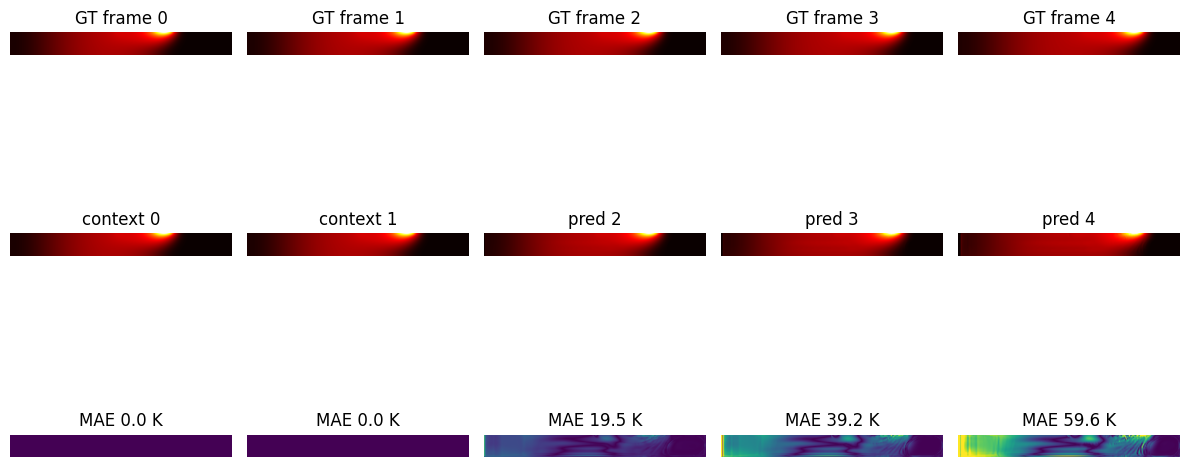

In [10]:
total_frames = predictions_tensor.shape[0]
fig, axes = plt.subplots(3, total_frames, figsize=(2.4 * total_frames, 7.5))

vmin = float(ground_truth.min())
vmax = float(ground_truth.max())
error_vmax = 150.0

for idx in range(total_frames):
    gt = ground_truth[idx, 0].numpy()
    pred = predictions_tensor[idx, 0].numpy()

    axes[0, idx].imshow(gt, cmap="hot", vmin=vmin, vmax=vmax, origin="lower")
    axes[0, idx].set_title(f"GT frame {idx}")
    axes[0, idx].axis("off")

    axes[1, idx].imshow(pred, cmap="hot", vmin=vmin, vmax=vmax, origin="lower")
    title = "context" if idx < num_initial_frames else "pred"
    axes[1, idx].set_title(f"{title} {idx}")
    axes[1, idx].axis("off")

    err = np.abs(pred - gt)
    axes[2, idx].imshow(err, cmap="viridis", vmin=0, vmax=error_vmax, origin="lower")
    axes[2, idx].set_title(f"MAE {err.mean():.1f} K")
    axes[2, idx].axis("off")

plt.tight_layout()
plt.show()

### Error Evolution

Track MSE/MAE per frame to quantify how much the autoregressive rollout drifts as we step forward.

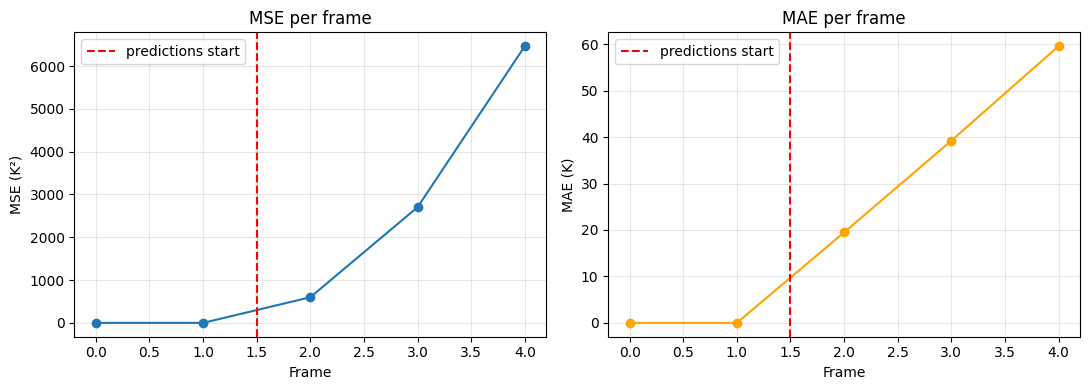

[{'frame': 2, 'mse': 598.8301391601562, 'mae': 19.47652244567871},
 {'frame': 3, 'mse': 2702.5703125, 'mae': 39.224395751953125},
 {'frame': 4, 'mse': 6464.54052734375, 'mae': 59.577232360839844}]

In [11]:
mae_series = [0.0] * num_initial_frames + [m["mae"] for m in frame_metrics]
mse_series = [0.0] * num_initial_frames + [m["mse"] for m in frame_metrics]
frames = list(range(len(mae_series)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.plot(frames, mse_series, marker="o")
ax1.axvline(num_initial_frames - 0.5, color="red", linestyle="--", label="predictions start")
ax1.set_title("MSE per frame")
ax1.set_xlabel("Frame")
ax1.set_ylabel("MSE (K²)")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(frames, mae_series, marker="o", color="orange")
ax2.axvline(num_initial_frames - 0.5, color="red", linestyle="--", label="predictions start")
ax2.set_title("MAE per frame")
ax2.set_xlabel("Frame")
ax2.set_ylabel("MAE (K)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

frame_metrics